In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

from pathlib import Path
import random

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
import torch
torch.cuda.set_device(3)

In [3]:
%matplotlib inline
import numpy as np



Function por stablishing the seed for reproducibility


In [4]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
path = Path("dataset/")
path_images = path/"Images"
path_labels = path/"Labels"

test_name = "test"

Obtaining the label associated with an image, in the case of segmentation it is a mask

In [6]:
get_y_fn = lambda x: Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))



Aux function for splitting between training and testing


In [7]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

Loading the codes of the different classes. All the datasets have the same codes.

In [8]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [9]:
def msa(input, target):
    target = target.squeeze(1)
    mask = target != -1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def background(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def leaves(input, target):
    target = target.squeeze(1)
    mask = target != 1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def wood(input, target):
    target = target.squeeze(1)
    mask = target != 2
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def pole(input, target):
    target = target.squeeze(1)
    mask = target != 3
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def grape(input, target):
    target = target.squeeze(1)
    mask = target != 4
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

Early Stopping parameters

In [10]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=2

In [11]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [12]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [13]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 4
        mask[mask==255]=4
        mask[mask==150]=1
        mask[mask==76]=3
        mask[mask==74]=3
        mask[mask==29]=2
        mask[mask==25]=2
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [14]:
path_manual_img = path_images/'train'
path_manual_lbl = path_labels/'train'

dataset/Images/train/color_159.jpg


<AxesSubplot:>

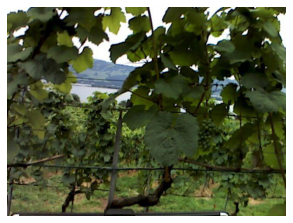

In [15]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [16]:
print(get_y_fn(img_f))

dataset/Labels/train/gt_159.png


<AxesSubplot:>

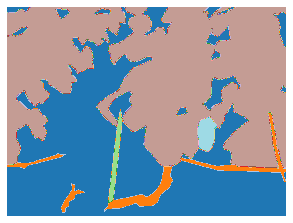

In [17]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [18]:
np.unique(np.array(mask))

array([  0,  29,  76, 150, 255], dtype=uint8)

In [19]:
bs = 4

In [20]:
codes

array(['Background', 'Leaves', 'Wood', 'Pole', 'Grape'], dtype='<U10')

In [21]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
#manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
#dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [22]:
#x,mask=dls.one_batch()

# FocalLoss

In [23]:
learn = get_segmentation_learner(dls=dls, number_classes=5, segmentation_type="Semantic Segmentation",
                                 architecture_name="unet", backbone_name="resnet34", 
                                 metrics=[background,leaves,pole,grape,wood,msa],wd=1e-2,
                                 pretrained=True,normalize=True).to_fp16()

In [24]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()
    


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [25]:
dls.loss_func = MixedLoss(10.0, 2.0)

In [26]:
#learn.lr_find() # find learning rate
#learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,background,leaves,pole,grape,wood,msa,time
0,1.349390,1.091822,0.024392,0.864920,0.504079,0.502724,0.506341,0.496935,00:11
1,1.100499,0.816975,0.841889,0.379718,0.631796,0.630044,0.634534,0.622690,00:12
2,0.884089,0.644065,0.810834,0.617146,0.752063,0.750010,0.755364,0.741280,00:11
3,0.731706,0.641918,0.866434,0.601371,0.768739,0.766627,0.771150,0.757711,00:12
4,0.628928,0.598586,0.869314,0.629144,0.781347,0.779333,0.780049,0.770451,00:12
5,0.554184,0.496307,0.859014,0.691658,0.808674,0.807500,0.807511,0.798353,00:12
6,0.500426,0.564578,0.890736,0.600782,0.774826,0.772327,0.776183,0.764726,00:11
7,0.450074,0.465113,0.878047,0.735102,0.827980,0.823850,0.830848,0.821277,00:11
8,0.406228,0.425671,0.847992,0.773004,0.838836,0.836771,0.841910,0.831623,00:11
9,0.372641,0.417643,0.859127,0.768314,0.837823,0.832278,0.841968,0.830859,00:12


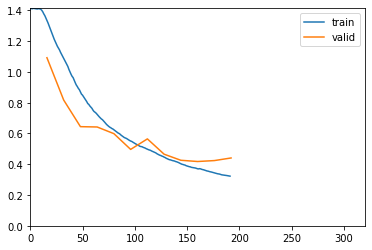

Better model found at epoch 0 with valid_loss value: 1.0918223857879639.
Better model found at epoch 1 with valid_loss value: 0.8169751167297363.
Better model found at epoch 2 with valid_loss value: 0.6440653800964355.
Better model found at epoch 3 with valid_loss value: 0.6419175267219543.
Better model found at epoch 4 with valid_loss value: 0.5985857248306274.
Better model found at epoch 5 with valid_loss value: 0.4963070750236511.
Better model found at epoch 7 with valid_loss value: 0.46511295437812805.
Better model found at epoch 8 with valid_loss value: 0.4256708323955536.
Better model found at epoch 9 with valid_loss value: 0.4176429808139801.
No improvement since epoch 9: early stopping


In [27]:
fname="unet-manual-no-data-augmentation-before-unfreeze-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-5,1e-4),cbs=callbacksFitBeforeUnfreeze)

Recorder

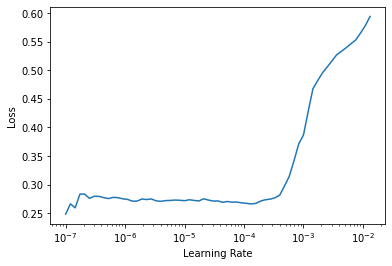

In [28]:
learn.load("unet-manual-no-data-augmentation-before-unfreeze-WD-1-best")
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,background,leaves,pole,grape,wood,msa,time
0,0.276667,0.418962,0.860473,0.764108,0.836993,0.831837,0.841010,0.829861,00:12
1,0.278314,0.414188,0.856597,0.772843,0.839465,0.834401,0.843761,0.832536,00:12
2,0.280190,0.414273,0.856797,0.773009,0.839948,0.834496,0.843933,0.832773,00:12
3,0.277268,0.412211,0.854937,0.776255,0.840817,0.835502,0.845125,0.833760,00:12
4,0.277348,0.415902,0.859289,0.767712,0.838000,0.833264,0.842479,0.831180,00:11
5,0.279547,0.413881,0.856764,0.771624,0.839231,0.834336,0.843595,0.832263,00:12


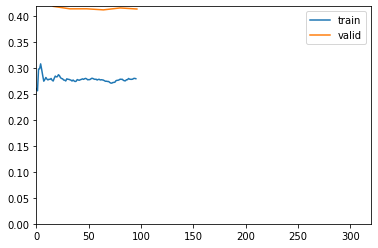

Better model found at epoch 0 with valid_loss value: 0.4189620316028595.
Better model found at epoch 1 with valid_loss value: 0.4141881763935089.
Better model found at epoch 3 with valid_loss value: 0.412210613489151.
No improvement since epoch 3: early stopping


In [29]:
fname="unet-manual-no-data-augmentation-after-unfreeze-WD-1-best"

callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-7,1e-7),cbs=callbacksFitAfterUnfreeze)

In [30]:
learn.validate()

(#7) [0.412210613489151,0.8549370169639587,0.7762545347213745,0.8408167958259583,0.835502028465271,0.8451245427131653,0.8337602615356445]